# 📊 Classificação de Custo-Benefício de Smartphones (RandomForest)

Este notebook realiza a criação de uma variável `CustoBeneficio` (baixo, médio, alto) com base em características técnicas dos smartphones,
como bateria, memória, câmeras, tela e preço. Em seguida, treinamos um modelo de classificação **Random Forest** para prever essa categoria
com base nos dados, e avaliamos a performance do modelo com matriz de confusão e métricas de classificação.


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Display settings
plt.rcParams.update({"axes.labelsize": 11, "axes.titlesize": 13, "figure.autolayout": True})
sns.set_style("whitegrid")

# Set this to your Excel file path
EXCEL_FILE = "D:/Projetos/faculdade/PISI3GP6/datasets/pisi3basededados.xlsx"

In [26]:
import utils

df = pd.read_excel(EXCEL_FILE)
df.columns = df.columns.str.strip()

df = utils.dataframe_convert_columns(df)

df.drop(columns=[
    "Mobile Weight", "Launched Price (USA)", "Battery Capacity", "RAM",
    "Front Camera", "Back Camera", "Screen Size", "Launched Year",
    "Company Name", "Model Name", "Processor", "Sistema Operacional",
    "Ano", "Marca", "Preço (R$)", "Sistema Operacional (Binário)", "Peso (g)"
], inplace=True)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (373, 6)


,Preço (USD),Memoria Interna (GB),Câmera Frontal (MP),Câmera Traseira (MP),Tela (polegadas),Bateria (mAh)
0,799.0,6.0,12.0,48.0,6.1,3600.0
1,849.0,6.0,12.0,48.0,6.1,3600.0
2,899.0,6.0,12.0,48.0,6.1,3600.0
3,899.0,6.0,12.0,48.0,6.7,4200.0
4,949.0,6.0,12.0,48.0,6.7,4200.0


### Normalizacao das colunas usadas para calcular o Score

In [27]:
# Colunas a serem consideradas
benefit_cols = ["Memoria Interna (GB)", "Câmera Frontal (MP)", "Câmera Traseira (MP)", "Tela (polegadas)", "Bateria (mAh)", "Preço (USD)"]
df_clean = df.dropna(subset=benefit_cols).copy()

# Normalização z-score
for col in benefit_cols:
    df_clean[f"z_{col}"] = (df_clean[col] - df_clean[col].mean()) / df_clean[col].std()

### Calculando o score e custo beneficio

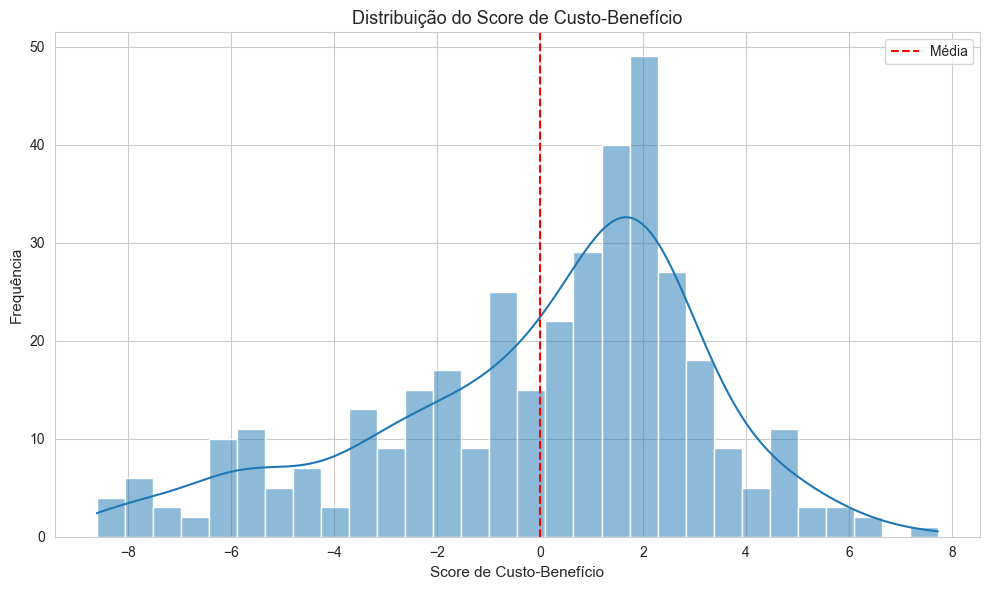

Dataset shape: (373, 6)


,z_Memoria Interna (GB),z_Câmera Frontal (MP),z_Câmera Traseira (MP),z_Tela (polegadas),z_Bateria (mAh),z_Preço (USD),CustoBeneficio
0,-0.506369,-0.472756,-0.047917,-1.174762,-1.161724,0.242041,Baixo
1,-0.506369,-0.472756,-0.047917,-1.174762,-1.161724,0.345259,Baixo
2,-0.506369,-0.472756,-0.047917,-1.174762,-1.161724,0.448477,Baixo
3,-0.506369,-0.472756,-0.047917,0.368147,-0.422572,0.448477,Baixo
4,-0.506369,-0.472756,-0.047917,0.368147,-0.422572,0.551695,Baixo


In [28]:
# Score ponderado
df_clean["score"] = (
    df_clean["z_Bateria (mAh)"] +
    df_clean["z_Câmera Traseira (MP)"] * 0.7 +
    df_clean["z_Câmera Frontal (MP)"] * 0.3 +
    df_clean["z_Memoria Interna (GB)"] +
    df_clean["z_Tela (polegadas)"] -
    df_clean["z_Preço (USD)"] * 1.5
)

# Classificação em faixas
df_clean["CustoBeneficio"] = pd.qcut(df_clean["score"], 3, labels=["Baixo", "Médio", "Alto"])

# Visualização da distribuição do score
plt.figure(figsize=(10, 6))
sns.histplot(df_clean["score"], bins=30, kde=True)
plt.title("Distribuição do Score de Custo-Benefício")
plt.xlabel("Score de Custo-Benefício")
plt.ylabel("Frequência")
plt.axvline(df_clean["score"].mean(), color='red', linestyle='--', label='Média')
plt.legend()
plt.show()

# Remove colunas iniciais
df_clean.drop(columns=(benefit_cols + ["score"]), inplace=True)

print("Dataset shape:", df.shape)
df_clean.head()

### Separando os dados de treino e teste

In [29]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df_clean.drop('CustoBeneficio', axis=1)
y = df_clean['CustoBeneficio']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (261, 6)
Testing set shape: (112, 6)


### Treinando o modelo e fazendo predicoes

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

### Importancia das features

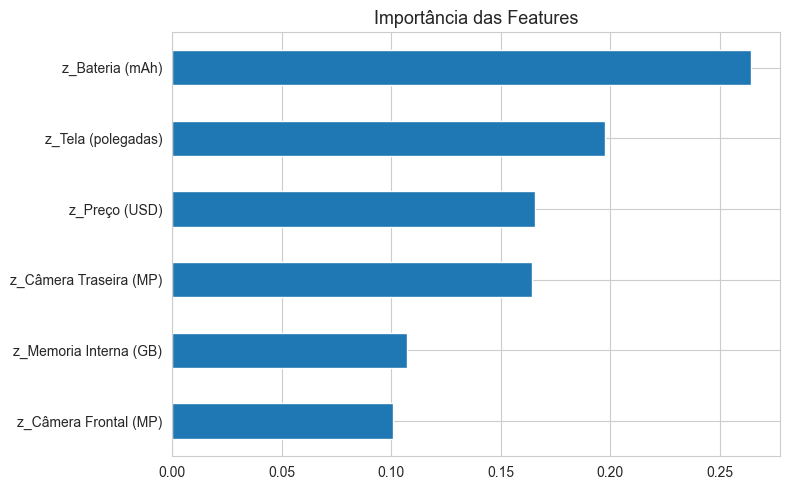

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Importância das features
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8,5), title='Importância das Features')
plt.show()

### Gerando a matriz de confusao


Classification Report - Test Data:
              precision    recall  f1-score   support

        Alto       0.86      0.94      0.90        33
       Baixo       0.98      0.93      0.95        43
       Médio       0.86      0.83      0.85        36

    accuracy                           0.90       112
   macro avg       0.90      0.90      0.90       112
weighted avg       0.90      0.90      0.90       112



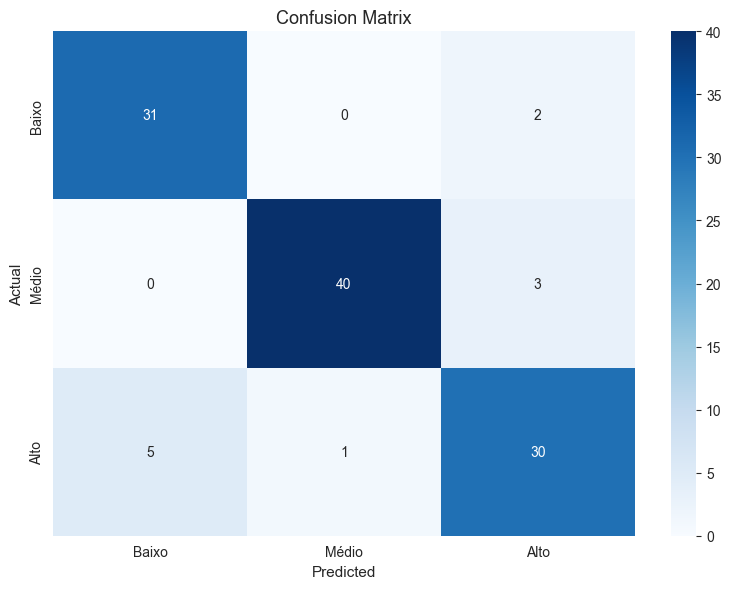


Classification Report - Training Data:
              precision    recall  f1-score   support

        Alto       1.00      1.00      1.00        92
       Baixo       1.00      1.00      1.00        81
       Médio       1.00      1.00      1.00        88

    accuracy                           1.00       261
   macro avg       1.00      1.00      1.00       261
weighted avg       1.00      1.00      1.00       261



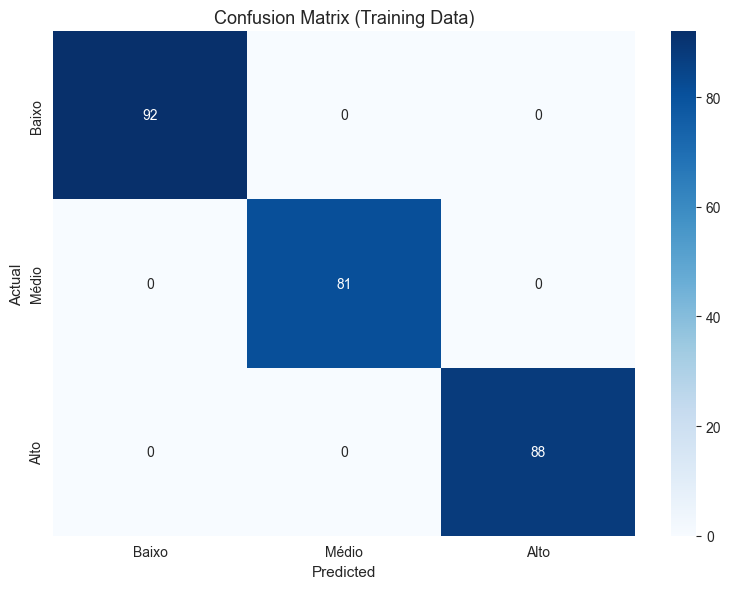

In [32]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nClassification Report - Test Data:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Baixo', 'Médio', 'Alto'], 
            yticklabels=['Baixo', 'Médio', 'Alto'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Make predictions on training data
y_train_pred = rf_model.predict(X_train)

# Generate the confusion matrix for training data
train_conf_matrix = confusion_matrix(y_train, y_train_pred)

print("\nClassification Report - Training Data:")
print(classification_report(y_train, y_train_pred))

# Plot the confusion matrix for training data
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Baixo', 'Médio', 'Alto'], 
            yticklabels=['Baixo', 'Médio', 'Alto'])
plt.title('Confusion Matrix (Training Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Partial Dependence Plots (PDP)

     z_Memoria Interna (GB)  z_Câmera Frontal (MP)  z_Câmera Traseira (MP)  \
327                1.444153              -0.384028                0.013714   
33                -0.506369              -0.472756               -0.047917   
15                -0.506369              -0.472756               -0.047917   
314                0.143805               3.786185                0.013714   
57                -0.506369              -0.472756               -1.157280   

     z_Tela (polegadas)  z_Bateria (mAh)  z_Preço (USD)  
327            0.625299         0.624561       0.861348  
33             0.368147        -0.052996       1.067784  
15             0.368147        -0.299380       0.448477  
314            0.573868        -0.052996      -0.170831  
57             0.368147        -1.054547       0.861348  


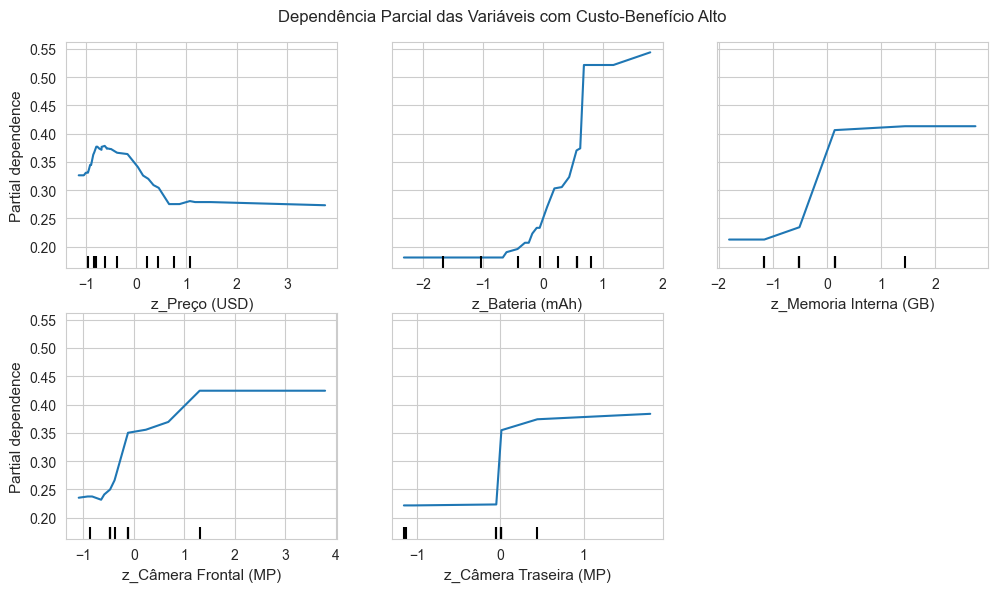

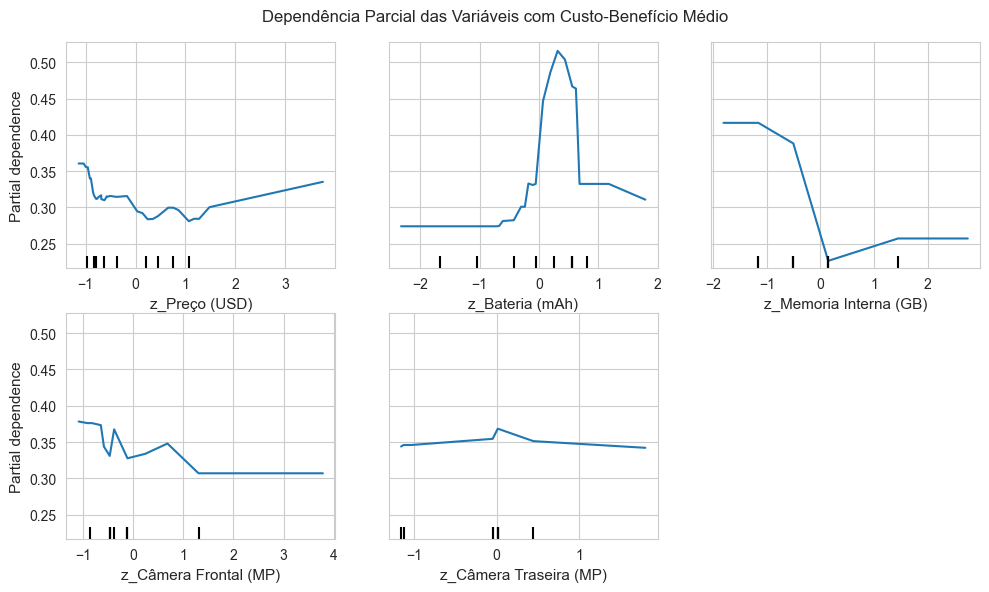

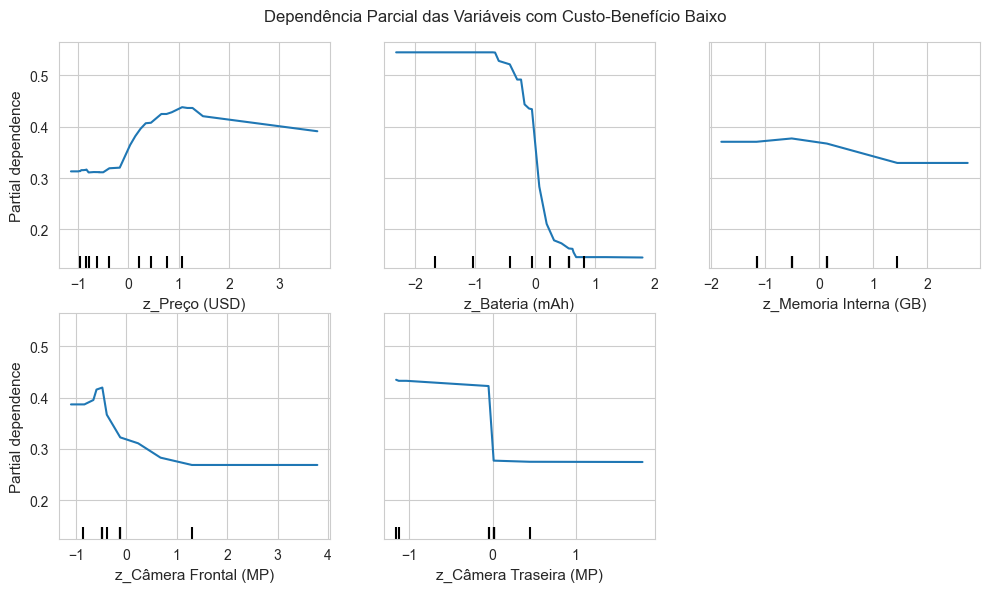

In [51]:
from sklearn.inspection import PartialDependenceDisplay

print(X_test.head())

fig, ax = plt.subplots(figsize=(10, 6))

PartialDependenceDisplay.from_estimator(rf_model, X_test, features=['z_Preço (USD)', 'z_Bateria (mAh)', 'z_Memoria Interna (GB)', 'z_Câmera Frontal (MP)', 'z_Câmera Traseira (MP)'], kind='average', target='Alto', grid_resolution=200, ax=ax)
plt.suptitle("Dependência Parcial das Variáveis com Custo-Benefício Alto")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

PartialDependenceDisplay.from_estimator(rf_model, X_test, features=['z_Preço (USD)', 'z_Bateria (mAh)', 'z_Memoria Interna (GB)', 'z_Câmera Frontal (MP)', 'z_Câmera Traseira (MP)'], kind='average', target='Médio', grid_resolution=200, ax=ax)
plt.suptitle("Dependência Parcial das Variáveis com Custo-Benefício Médio")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

PartialDependenceDisplay.from_estimator(rf_model, X_test, features=['z_Preço (USD)', 'z_Bateria (mAh)', 'z_Memoria Interna (GB)', 'z_Câmera Frontal (MP)', 'z_Câmera Traseira (MP)'], kind='average', target='Baixo', grid_resolution=200, ax=ax)
plt.suptitle("Dependência Parcial das Variáveis com Custo-Benefício Baixo")
plt.tight_layout()
plt.show()

### Gráfico de Precisão (accuracy) por n_estimators

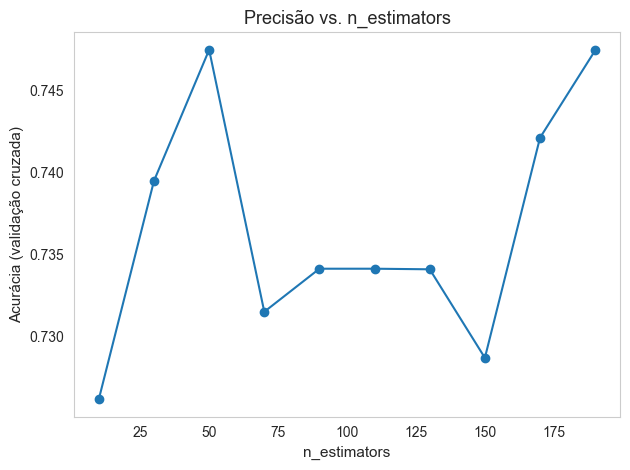

In [33]:
from sklearn.model_selection import cross_val_score

scores = []
estimators = list(range(10, 201, 20))

for n in estimators:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
    scores.append(score)

plt.plot(estimators, scores, marker='o')
plt.title("Precisão vs. n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Acurácia (validação cruzada)")
plt.grid()
plt.show()

### Regularizando os dados para consertar o overfitting

In [34]:
from sklearn.metrics import accuracy_score

# Train a Random Forest Classifier
rf_model_regularized = RandomForestClassifier(
    n_estimators=50, 
    random_state=42, 
    max_depth=10,  # Regularization parameter
    min_samples_split=10,  # Regularization parameter
    min_samples_leaf=5,       # Mín amostras por folha
    max_features='sqrt',       # Usa sqrt(n_features) por árvore
)
rf_model_regularized.fit(X_train, y_train)

# Make predictions
y_pred_train = rf_model_regularized.predict(X_train)
y_pred_test = rf_model_regularized.predict(X_test)

# Métricas
train_acc_reg = accuracy_score(y_train, y_pred_train)
test_acc_reg = accuracy_score(y_test, y_pred_test)

print(f"Acurácia Treino: {train_acc_reg:.3f}")
print(f"Acurácia Teste: {test_acc_reg:.3f}")
print(f"Diferença: {train_acc_reg - test_acc_reg:.3f}")

print("\nClassification Report - Teste:")
print(classification_report(y_test, y_pred_test))


Acurácia Treino: 0.920
Acurácia Teste: 0.893
Diferença: 0.027

Classification Report - Teste:
              precision    recall  f1-score   support

        Alto       0.88      0.88      0.88        33
       Baixo       0.98      0.93      0.95        43
       Médio       0.82      0.86      0.84        36

    accuracy                           0.89       112
   macro avg       0.89      0.89      0.89       112
weighted avg       0.90      0.89      0.89       112



## 🎯 SMOTE para Balanceamento de Classes e Redução de Overfitting

SMOTE (Synthetic Minority Oversampling Technique) pode ajudar a reduzir overfitting quando há desbalanceamento de classes, criando exemplos sintéticos das classes minoritárias.

=== DISTRIBUIÇÃO DAS CLASSES ===
Distribuição original:
  Classe Alto: 125 amostras (33.5%)
  Classe Baixo: 124 amostras (33.2%)
  Classe Médio: 124 amostras (33.2%)

Distribuição no treino:
  Classe Alto: 92 amostras (35.2%)
  Classe Baixo: 81 amostras (31.0%)
  Classe Médio: 88 amostras (33.7%)


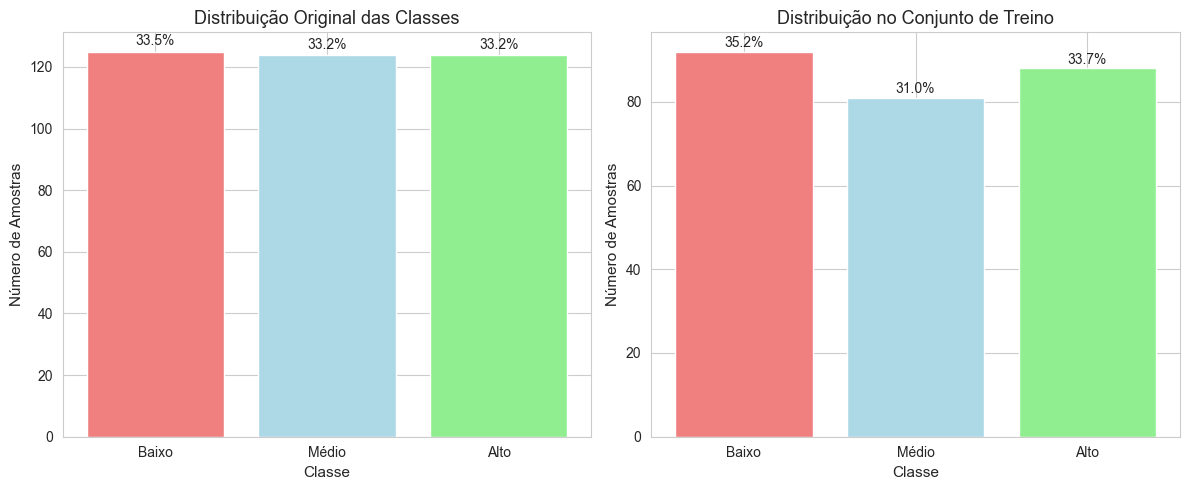


Índice de desbalanceamento: 1.14
✅ Dataset relativamente balanceado


In [35]:
# 1. Análise da Distribuição das Classes
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

print("=== DISTRIBUIÇÃO DAS CLASSES ===")

# Verificar distribuição original
y_counts = Counter(y)
print("Distribuição original:")
for classe, count in sorted(y_counts.items()):
    percentage = (count / len(y)) * 100
    print(f"  Classe {classe}: {count} amostras ({percentage:.1f}%)")

# Verificar distribuição no conjunto de treino
y_train_counts = Counter(y_train)
print("\nDistribuição no treino:")
for classe, count in sorted(y_train_counts.items()):
    percentage = (count / len(y_train)) * 100
    print(f"  Classe {classe}: {count} amostras ({percentage:.1f}%)")

# Visualizar distribuição
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico da distribuição original
classes, counts = zip(*sorted(y_counts.items()))
ax1.bar(classes, counts, color=['lightcoral', 'lightblue', 'lightgreen'])
ax1.set_title('Distribuição Original das Classes')
ax1.set_xlabel('Classe')
ax1.set_ylabel('Número de Amostras')
ax1.set_xticks(classes)
ax1.set_xticklabels(['Baixo', 'Médio', 'Alto'])

# Adicionar percentuais
for i, (classe, count) in enumerate(sorted(y_counts.items())):
    percentage = (count / len(y)) * 100
    ax1.text(classe, count + 2, f'{percentage:.1f}%', ha='center')

# Gráfico da distribuição do treino
classes_train, counts_train = zip(*sorted(y_train_counts.items()))
ax2.bar(classes_train, counts_train, color=['lightcoral', 'lightblue', 'lightgreen'])
ax2.set_title('Distribuição no Conjunto de Treino')
ax2.set_xlabel('Classe')
ax2.set_ylabel('Número de Amostras')
ax2.set_xticks(classes_train)
ax2.set_xticklabels(['Baixo', 'Médio', 'Alto'])

# Adicionar percentuais
for i, (classe, count) in enumerate(sorted(y_train_counts.items())):
    percentage = (count / len(y_train)) * 100
    ax2.text(classe, count + 1, f'{percentage:.1f}%', ha='center')

plt.tight_layout()
plt.show()

# Calcular índice de desbalanceamento
max_count = max(y_train_counts.values())
min_count = min(y_train_counts.values())
imbalance_ratio = max_count / min_count

print(f"\nÍndice de desbalanceamento: {imbalance_ratio:.2f}")
if imbalance_ratio > 2:
    print("⚠️  Dataset desbalanceado - SMOTE pode ajudar!")
else:
    print("✅ Dataset relativamente balanceado")


=== APLICANDO TÉCNICAS DE BALANCEAMENTO ===

Original:
Tamanho original do treino: 261 amostras
Tamanho após *Original*: 261 amostras
Aumento: 0 amostras sintéticas
  Classe Alto: 92 amostras (35.2%)
  Classe Baixo: 81 amostras (31.0%)
  Classe Médio: 88 amostras (33.7%)

Classification Report - RF (Original - Test Set):
              precision    recall  f1-score   support

        Alto       0.88      0.88      0.88        33
       Baixo       0.98      0.93      0.95        43
       Médio       0.82      0.86      0.84        36

    accuracy                           0.89       112
   macro avg       0.89      0.89      0.89       112
weighted avg       0.90      0.89      0.89       112


Classification Report - RF (Original - Training Set):
              precision    recall  f1-score   support

        Alto       0.93      0.93      0.93        92
       Baixo       0.97      0.91      0.94        81
       Médio       0.86      0.91      0.88        88

    accuracy          

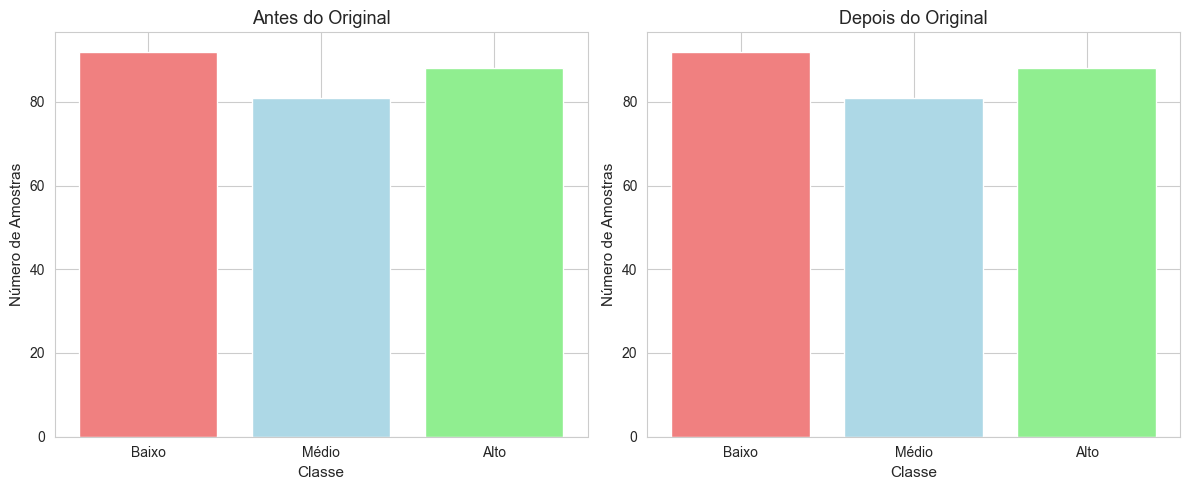


Oversampling:
Tamanho original do treino: 261 amostras
Tamanho após *Oversampling*: 276 amostras
Aumento: 15 amostras sintéticas
  Classe Alto: 92 amostras (33.3%)
  Classe Baixo: 92 amostras (33.3%)
  Classe Médio: 92 amostras (33.3%)

Classification Report - RF (Oversampling - Test Set):
              precision    recall  f1-score   support

        Alto       0.88      0.88      0.88        33
       Baixo       0.98      0.95      0.96        43
       Médio       0.84      0.86      0.85        36

    accuracy                           0.90       112
   macro avg       0.90      0.90      0.90       112
weighted avg       0.90      0.90      0.90       112


Classification Report - RF (Oversampling - Training Set):
              precision    recall  f1-score   support

        Alto       0.97      0.95      0.96        92
       Baixo       0.97      0.93      0.95        92
       Médio       0.89      0.93      0.91        92

    accuracy                           0.94       

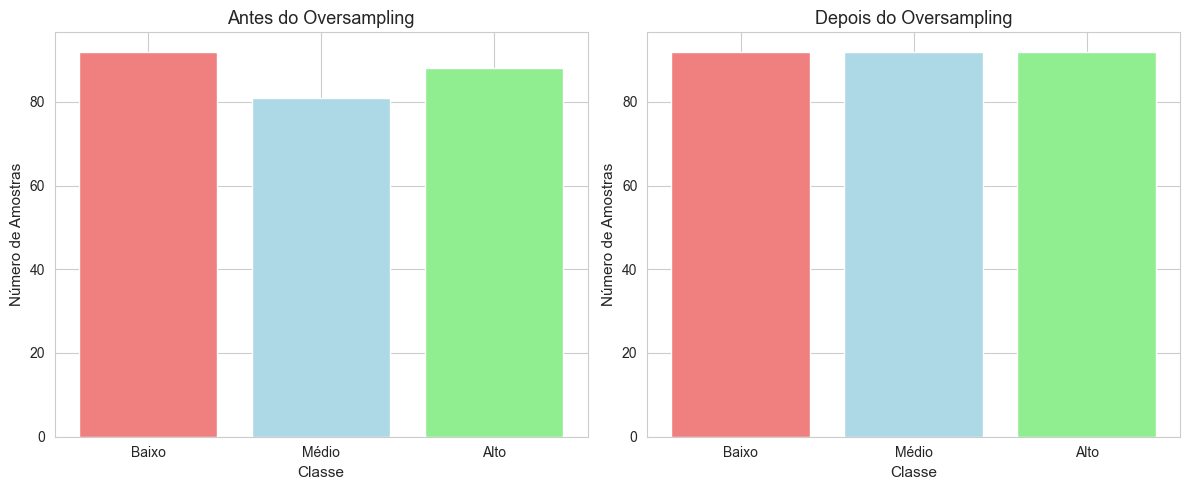


Undersampling:
Tamanho original do treino: 261 amostras
Tamanho após *Undersampling*: 243 amostras
Aumento: -18 amostras sintéticas
  Classe Alto: 81 amostras (33.3%)
  Classe Baixo: 81 amostras (33.3%)
  Classe Médio: 81 amostras (33.3%)

Classification Report - RF (Undersampling - Test Set):
              precision    recall  f1-score   support

        Alto       0.88      0.91      0.90        33
       Baixo       0.95      0.93      0.94        43
       Médio       0.83      0.83      0.83        36

    accuracy                           0.89       112
   macro avg       0.89      0.89      0.89       112
weighted avg       0.89      0.89      0.89       112


Classification Report - RF (Undersampling - Training Set):
              precision    recall  f1-score   support

        Alto       0.96      0.93      0.94        81
       Baixo       0.99      0.90      0.94        81
       Médio       0.85      0.95      0.90        81

    accuracy                           0.93  

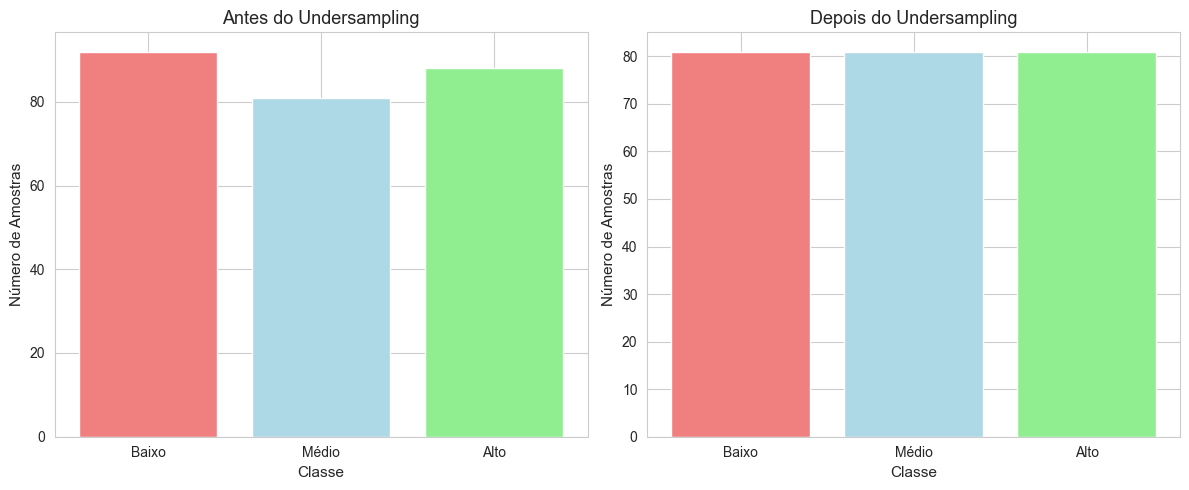


SMOTE:
Tamanho original do treino: 261 amostras
Tamanho após *SMOTE*: 276 amostras
Aumento: 15 amostras sintéticas
  Classe Alto: 92 amostras (33.3%)
  Classe Baixo: 92 amostras (33.3%)
  Classe Médio: 92 amostras (33.3%)

Classification Report - RF (SMOTE - Test Set):
              precision    recall  f1-score   support

        Alto       0.79      0.82      0.81        33
       Baixo       0.98      0.93      0.95        43
       Médio       0.76      0.78      0.77        36

    accuracy                           0.85       112
   macro avg       0.84      0.84      0.84       112
weighted avg       0.85      0.85      0.85       112


Classification Report - RF (SMOTE - Training Set):
              precision    recall  f1-score   support

        Alto       0.96      0.92      0.94        92
       Baixo       0.98      0.93      0.96        92
       Médio       0.87      0.93      0.90        92

    accuracy                           0.93       276
   macro avg       0.93 

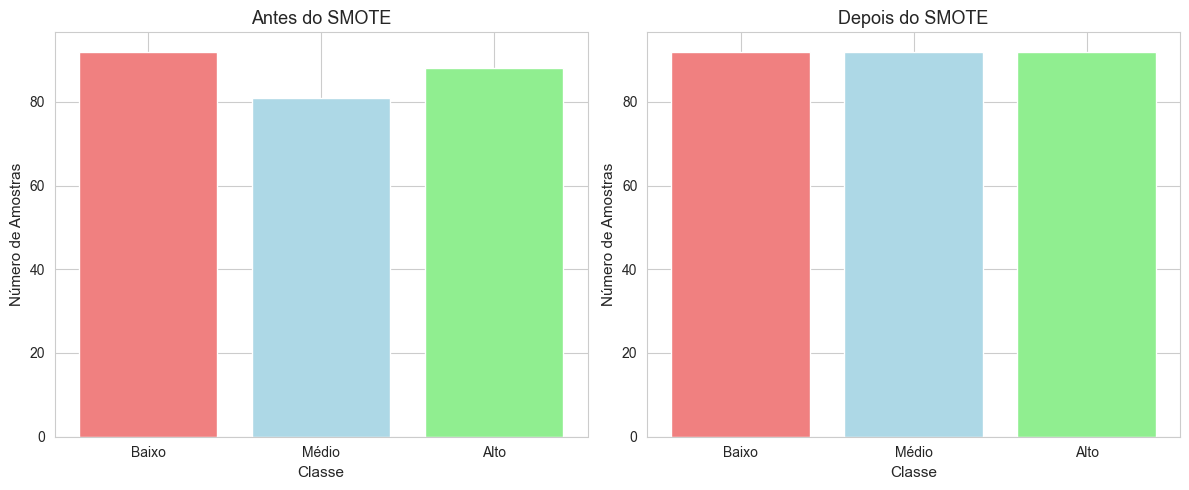


SMOTEENN:
Tamanho original do treino: 261 amostras
Tamanho após *SMOTEENN*: 217 amostras
Aumento: -44 amostras sintéticas
  Classe Alto: 75 amostras (34.6%)
  Classe Baixo: 78 amostras (35.9%)
  Classe Médio: 64 amostras (29.5%)

Classification Report - RF (SMOTEENN - Test Set):
              precision    recall  f1-score   support

        Alto       0.80      0.85      0.82        33
       Baixo       0.93      0.95      0.94        43
       Médio       0.79      0.72      0.75        36

    accuracy                           0.85       112
   macro avg       0.84      0.84      0.84       112
weighted avg       0.85      0.85      0.85       112


Classification Report - RF (SMOTEENN - Training Set):
              precision    recall  f1-score   support

        Alto       0.99      0.96      0.97        75
       Baixo       0.99      0.99      0.99        78
       Médio       0.94      0.97      0.95        64

    accuracy                           0.97       217
   macro av

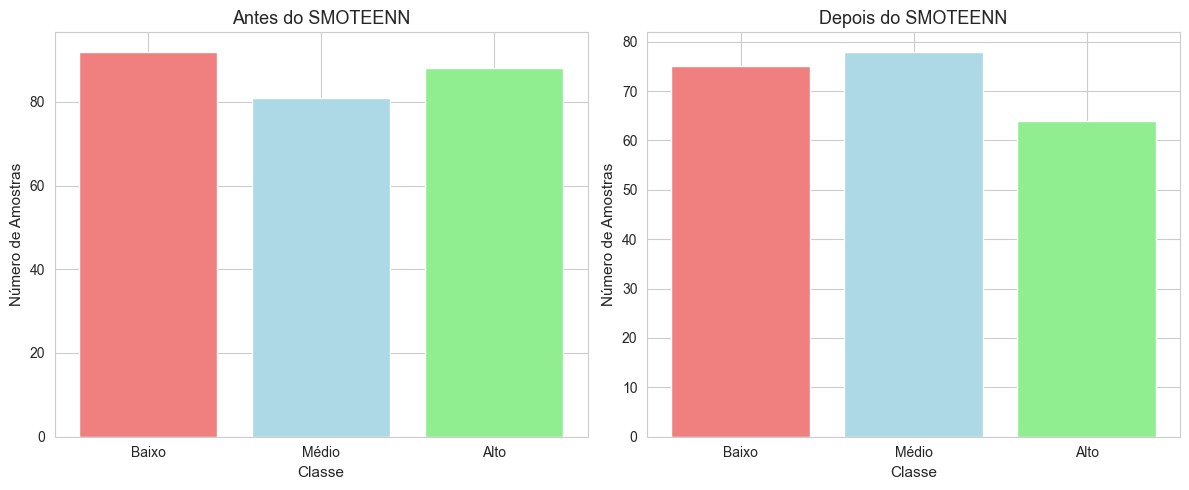

In [36]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

samplers_analysis = {
    "Original": (X_train, y_train),
    "Oversampling": RandomOverSampler(random_state=42, sampling_strategy='auto'),
    "Undersampling": RandomUnderSampler(random_state=42, sampling_strategy='auto'),
    "SMOTE": SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=5),
    "SMOTEENN": SMOTEENN(random_state=42, sampling_strategy='auto'),
}

# Parâmetros do modelo base para comparação justa
model_params = {
    'n_estimators': 50, 
    'random_state': 42, 
    'max_depth': 10,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'max_features': 'sqrt'
}

print("\n=== APLICANDO TÉCNICAS DE BALANCEAMENTO ===")
for name, sampler in samplers_analysis.items():
    print(f"\n{name}:")
    if name == 'Original':
        X_res, y_res = sampler
    else:
        X_res, y_res = sampler.fit_resample(X_train, y_train)

    print(f"Tamanho original do treino: {X_train.shape[0]} amostras")
    print(f"Tamanho após *{name}*: {X_res.shape[0]} amostras")
    print(f"Aumento: {X_res.shape[0] - X_train.shape[0]} amostras sintéticas")

    y_res_counts = Counter(y_res)

    for classe, count in sorted(Counter(y_res).items()):
        percentage = (count / len(y_res)) * 100
        print(f"  Classe {classe}: {count} amostras ({percentage:.1f}%)")
        
    # Treinar modelo
    rf_model = RandomForestClassifier(**model_params)
    rf_model.fit(X_res, y_res)
    
    # Predições
    X_test_scaled = X_test.copy()  # Preservar X_test original para visualização
    y_test_pred = rf_model.predict(X_test_scaled)
    y_train_pred = rf_model.predict(X_res)

    # Generate and print the classification report for the test set
    print(f"\nClassification Report - RF ({name} - Test Set):")
    print(classification_report(y_test, y_test_pred))

    # Optional: Predict on the resampled training set and print report
    print(f"\nClassification Report - RF ({name} - Training Set):")
    print(classification_report(y_res, y_train_pred))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Antes do SMOTE
    classes_before, counts_before = zip(*sorted(y_train_counts.items()))
    ax1.bar(classes_before, counts_before, color=['lightcoral', 'lightblue', 'lightgreen'])
    ax1.set_title(f'Antes do {name}')
    ax1.set_xlabel('Classe')
    ax1.set_ylabel('Número de Amostras')
    ax1.set_xticks(classes_before)
    ax1.set_xticklabels(['Baixo', 'Médio', 'Alto'])

    # Depois do SMOTE
    classes_after, counts_after = zip(*sorted(y_res_counts.items()))
    ax2.bar(classes_after, counts_after, color=['lightcoral', 'lightblue', 'lightgreen'])
    ax2.set_title(f'Depois do {name}')
    ax2.set_xlabel('Classe')
    ax2.set_ylabel('Número de Amostras')
    ax2.set_xticks(classes_after)
    ax2.set_xticklabels(['Baixo', 'Médio', 'Alto'])

    plt.tight_layout()
    plt.show()

In [37]:
# Análise Comparativa Quantitativa das Técnicas de Balanceamento
from sklearn.model_selection import cross_val_score
import pandas as pd

print("\n" + "="*80)
print("📊 ANÁLISE COMPARATIVA QUANTITATIVA - TÉCNICAS DE BALANCEAMENTO")
print("="*80)

# Dicionário para armazenar resultados
results_comparison = {}

for name, sampler in samplers_analysis.items():
    print(f"\n--- Analisando {name} ---")
    
    # Preparar dados
    if name == 'Original':
        X_res, y_res = sampler
    else:
        X_res, y_res = sampler.fit_resample(X_train, y_train)

    # Treinar modelo
    rf_model = RandomForestClassifier(**model_params)
    rf_model.fit(X_res, y_res)
    
    # Predições
    X_test_scaled = X_test.copy()  # Preservar X_test original para visualização
    y_test_pred = rf_model.predict(X_test_scaled)
    y_train_pred = rf_model.predict(X_train)
    
    # Métricas básicas
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    overfitting_gap = train_acc - test_acc
    
    # Validação cruzada no conjunto original (sem balanceamento)
    cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Métricas por classe (macro average)
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='macro')
    
    # Armazenar resultados
    results_comparison[name] = {
        'Samples': len(X_res),
        'Train_Acc': train_acc,
        'Test_Acc': test_acc,
        'Overfitting_Gap': overfitting_gap,
        'CV_Mean': cv_mean,
        'CV_Std': cv_std,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    }
    
    print(f"  Amostras de treino: {len(X_res)}")
    print(f"  Acurácia treino: {train_acc:.3f}")
    print(f"  Acurácia teste: {test_acc:.3f}")
    print(f"  Gap overfitting: {overfitting_gap:.3f}")
    print(f"  CV score: {cv_mean:.3f} ± {cv_std:.3f}")
    print(f"  F1 macro: {f1:.3f}")


📊 ANÁLISE COMPARATIVA QUANTITATIVA - TÉCNICAS DE BALANCEAMENTO

--- Analisando Original ---
  Amostras de treino: 261
  Acurácia treino: 0.920
  Acurácia teste: 0.893
  Gap overfitting: 0.027
  CV score: 0.721 ± 0.101
  F1 macro: 0.890

--- Analisando Oversampling ---
  Amostras de treino: 276
  Acurácia treino: 0.939
  Acurácia teste: 0.902
  Gap overfitting: 0.037
  CV score: 0.721 ± 0.101
  F1 macro: 0.898

--- Analisando Undersampling ---
  Amostras de treino: 243
  Acurácia treino: 0.927
  Acurácia teste: 0.893
  Gap overfitting: 0.034
  CV score: 0.721 ± 0.101
  F1 macro: 0.890

--- Analisando SMOTE ---
  Amostras de treino: 276
  Acurácia treino: 0.927
  Acurácia teste: 0.848
  Gap overfitting: 0.079
  CV score: 0.721 ± 0.101
  F1 macro: 0.842

--- Analisando SMOTEENN ---
  Amostras de treino: 217
  Acurácia treino: 0.862
  Acurácia teste: 0.848
  Gap overfitting: 0.014
  CV score: 0.721 ± 0.101
  F1 macro: 0.840


### Tabela comparativa final

In [38]:
# Criar DataFrame comparativo
df_results = pd.DataFrame(results_comparison).T
df_results = df_results.round(3)

print(f"\n{'='*80}")
print("📋 TABELA COMPARATIVA FINAL")
print(f"{'='*80}")
print(df_results)

# Análise e recomendações
best_overfitting = df_results['Overfitting_Gap'].idxmin()
best_test_acc = df_results['Test_Acc'].idxmax()
best_cv = df_results['CV_Mean'].idxmax()
best_f1 = df_results['F1_Score'].idxmax()

print(f"\n🏆 RANKINGS:")
print(f"• Menor overfitting: {best_overfitting} (gap: {df_results.loc[best_overfitting, 'Overfitting_Gap']:.3f})")
print(f"• Melhor acurácia teste: {best_test_acc} ({df_results.loc[best_test_acc, 'Test_Acc']:.3f})")
print(f"• Melhor validação cruzada: {best_cv} ({df_results.loc[best_cv, 'CV_Mean']:.3f})")
print(f"• Melhor F1-Score: {best_f1} ({df_results.loc[best_f1, 'F1_Score']:.3f})")

# Critério de decisão composto
# Normalizar métricas para criar score composto
df_normalized = df_results.copy()
df_normalized['Test_Acc_norm'] = df_normalized['Test_Acc'] / df_normalized['Test_Acc'].max()
df_normalized['CV_Mean_norm'] = df_normalized['CV_Mean'] / df_normalized['CV_Mean'].max()
df_normalized['F1_Score_norm'] = df_normalized['F1_Score'] / df_normalized['F1_Score'].max()
df_normalized['Overfitting_penalty'] = 1 - (df_normalized['Overfitting_Gap'] / df_normalized['Overfitting_Gap'].max())

# Score composto (maior é melhor)
weights = {'test_acc': 0.3, 'cv': 0.3, 'f1': 0.2, 'overfitting': 0.2}
df_normalized['Composite_Score'] = (
    weights['test_acc'] * df_normalized['Test_Acc_norm'] +
    weights['cv'] * df_normalized['CV_Mean_norm'] +
    weights['f1'] * df_normalized['F1_Score_norm'] +
    weights['overfitting'] * df_normalized['Overfitting_penalty']
)

best_overall = df_normalized['Composite_Score'].idxmax()

print(f"\n🎯 RECOMENDAÇÃO FINAL:")
print(f"Melhor técnica geral: {best_overall}")
print(f"Score composto: {df_normalized.loc[best_overall, 'Composite_Score']:.3f}")

if df_results.loc[best_overall, 'Overfitting_Gap'] < 0.05:
    print("✅ Esta técnica resolve o problema de overfitting!")
else:
    print("⚠️  Ainda há indícios de overfitting, mas é a melhor opção disponível")

print(f"\n💡 INSIGHTS:")
for technique in df_results.index:
    gap = df_results.loc[technique, 'Overfitting_Gap']
    if gap < 0.03:
        print(f"• {technique}: Excelente controle de overfitting")
    elif gap < 0.05:
        print(f"• {technique}: Bom controle de overfitting")
    else:
        print(f"• {technique}: Overfitting presente")


📋 TABELA COMPARATIVA FINAL
               Samples  Train_Acc  Test_Acc  Overfitting_Gap  CV_Mean  CV_Std  \
Original         261.0      0.920     0.893            0.027    0.721   0.101   
Oversampling     276.0      0.939     0.902            0.037    0.721   0.101   
Undersampling    243.0      0.927     0.893            0.034    0.721   0.101   
SMOTE            276.0      0.927     0.848            0.079    0.721   0.101   
SMOTEENN         217.0      0.862     0.848            0.014    0.721   0.101   

               Precision  Recall  F1_Score  
Original           0.890   0.890     0.890  
Oversampling       0.898   0.898     0.898  
Undersampling      0.889   0.891     0.890  
SMOTE              0.842   0.842     0.842  
SMOTEENN           0.840   0.841     0.840  

🏆 RANKINGS:
• Menor overfitting: SMOTEENN (gap: 0.014)
• Melhor acurácia teste: Oversampling (0.902)
• Melhor validação cruzada: Original (0.721)
• Melhor F1-Score: Oversampling (0.898)

🎯 RECOMENDAÇÃO FINAL:
Melho


📊 VISUALIZAÇÕES COMPARATIVAS


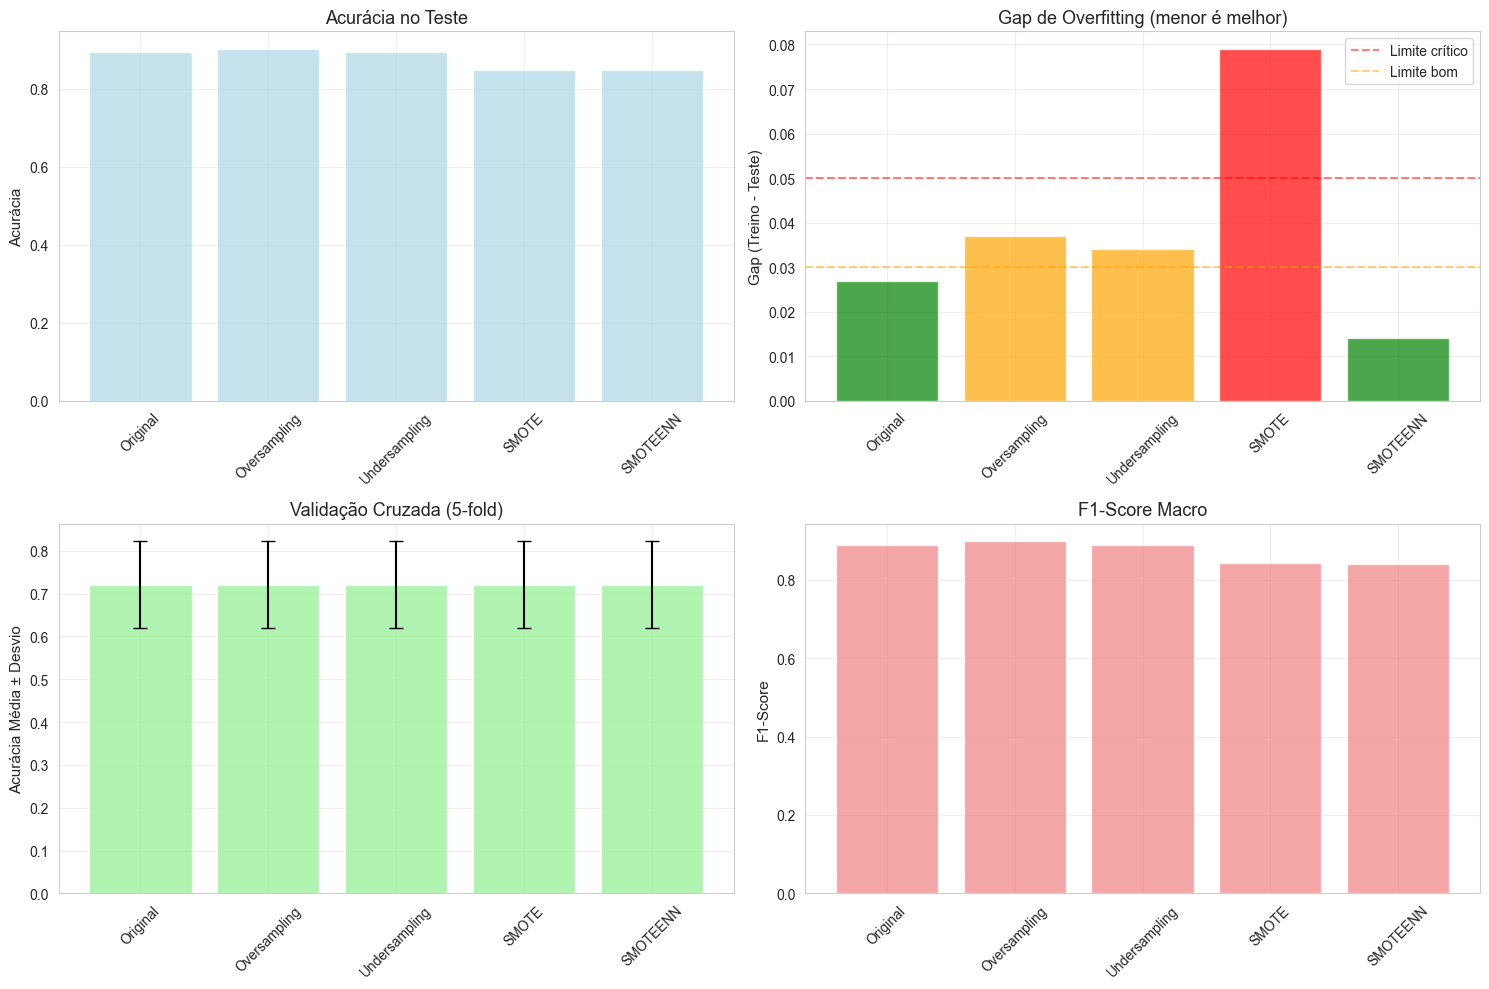


📈 ANÁLISE DE TRADE-OFFS:

Original:
  • Acurácia: 0.893
  • Overfitting: 0.027
  • Amostras: 261.0
  📝 Baseline - referência para comparação

Oversampling:
  • Acurácia: 0.902
  • Overfitting: 0.037
  • Amostras: 276.0
  📈 Duplicação simples - risco de overfitting

Undersampling:
  • Acurácia: 0.893
  • Overfitting: 0.034
  • Amostras: 243.0
  📉 Perda de informação - pode underfit

SMOTE:
  • Acurácia: 0.848
  • Overfitting: 0.079
  • Amostras: 276.0
  🧬 Dados sintéticos - pode melhorar generalização

SMOTEENN:
  • Acurácia: 0.848
  • Overfitting: 0.014
  • Amostras: 217.0
  🧬 Dados sintéticos - pode melhorar generalização

🎯 CONCLUSÃO:
A técnica 'SMOTEENN' oferece o melhor equilíbrio entre:
• Performance no teste
• Controle de overfitting
• Estabilidade (validação cruzada)
• Qualidade das predições (F1-score)


In [39]:
# Visualização Gráfica Comparativa
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*60)
print("📊 VISUALIZAÇÕES COMPARATIVAS")
print("="*60)

# 1. Gráfico de barras comparativo das principais métricas
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

techniques = df_results.index

# Acurácia de teste
ax1.bar(techniques, df_results['Test_Acc'], color='lightblue', alpha=0.7)
ax1.set_title('Acurácia no Teste')
ax1.set_ylabel('Acurácia')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Gap de overfitting
colors = ['red' if gap > 0.05 else 'orange' if gap > 0.03 else 'green' 
          for gap in df_results['Overfitting_Gap']]
ax2.bar(techniques, df_results['Overfitting_Gap'], color=colors, alpha=0.7)
ax2.set_title('Gap de Overfitting (menor é melhor)')
ax2.set_ylabel('Gap (Treino - Teste)')
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='Limite crítico')
ax2.axhline(y=0.03, color='orange', linestyle='--', alpha=0.5, label='Limite bom')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Validação cruzada
ax3.bar(techniques, df_results['CV_Mean'], color='lightgreen', alpha=0.7)
ax3.errorbar(techniques, df_results['CV_Mean'], yerr=df_results['CV_Std'], 
             fmt='none', color='black', capsize=5)
ax3.set_title('Validação Cruzada (5-fold)')
ax3.set_ylabel('Acurácia Média ± Desvio')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# F1-Score macro
ax4.bar(techniques, df_results['F1_Score'], color='lightcoral', alpha=0.7)
ax4.set_title('F1-Score Macro')
ax4.set_ylabel('F1-Score')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Análise de trade-offs
print(f"\n📈 ANÁLISE DE TRADE-OFFS:")

for technique in df_results.index:
    test_acc = df_results.loc[technique, 'Test_Acc']
    gap = df_results.loc[technique, 'Overfitting_Gap']
    samples = df_results.loc[technique, 'Samples']
    
    print(f"\n{technique}:")
    print(f"  • Acurácia: {test_acc:.3f}")
    print(f"  • Overfitting: {gap:.3f}")
    print(f"  • Amostras: {samples}")
    
    # Análise qualitativa
    if technique == 'Original':
        print(f"  📝 Baseline - referência para comparação")
    elif 'SMOTE' in technique:
        print(f"  🧬 Dados sintéticos - pode melhorar generalização")
    elif technique == 'Oversampling':
        print(f"  📈 Duplicação simples - risco de overfitting")
    elif technique == 'Undersampling':
        print(f"  📉 Perda de informação - pode underfit")

print(f"\n🎯 CONCLUSÃO:")
print(f"A técnica '{best_overall}' oferece o melhor equilíbrio entre:")
print(f"• Performance no teste")
print(f"• Controle de overfitting") 
print(f"• Estabilidade (validação cruzada)")
print(f"• Qualidade das predições (F1-score)")


🏆 MODELO FINAL OTIMIZADO
Técnica selecionada: SMOTEENN
Dados de treino final: 217 amostras

🔍 Executando otimização de hiperparâmetros...
(Isso pode levar alguns minutos)

✅ Otimização concluída!
Melhor score CV: 0.922

🎯 MELHORES HIPERPARÂMETROS:
  max_depth: 8
  max_features: sqrt
  min_samples_leaf: 4
  min_samples_split: 4
  n_estimators: 100

📊 PERFORMANCE FINAL:
Acurácia treino: 0.858
Acurácia teste: 0.866
Gap overfitting: -0.008
✅ Overfitting controlado com sucesso!
Validação cruzada final: 0.723 ± 0.116

📋 RELATÓRIO DE CLASSIFICAÇÃO FINAL:
              precision    recall  f1-score   support

       Baixo       0.81      0.91      0.86        33
       Médio       0.93      0.95      0.94        43
        Alto       0.84      0.72      0.78        36

    accuracy                           0.87       112
   macro avg       0.86      0.86      0.86       112
weighted avg       0.87      0.87      0.86       112



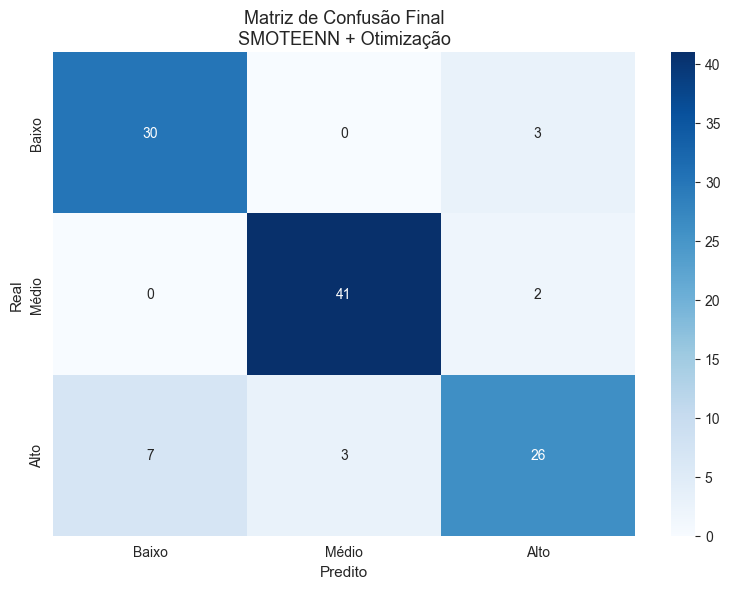

In [40]:
# Modelo Final Otimizado com a Melhor Técnica
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

print("\n" + "="*70)
print("🏆 MODELO FINAL OTIMIZADO")
print("="*70)

print(f"Técnica selecionada: {best_overall}")

# Preparar dados com a melhor técnica
if best_overall == 'Original':
    X_final, y_final = X_train, y_train
else:
    best_sampler = samplers_analysis[best_overall]
    X_final, y_final = best_sampler.fit_resample(X_train, y_train)

print(f"Dados de treino final: {X_final.shape[0]} amostras")

# Grid search para otimização de hiperparâmetros
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [6, 8, 10],
    'min_samples_split': [4, 6, 8, 10, 12],
    'min_samples_leaf': [4, 6, 8, 10, 12],
    'max_features': ['sqrt', 'log2']
}

print("\n🔍 Executando otimização de hiperparâmetros...")
print("(Isso pode levar alguns minutos)")

# GridSearch com validação cruzada
rf_grid_final = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,  # 3-fold para ser mais rápido
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

# Fit do grid search
rf_grid_final.fit(X_final, y_final)

print(f"\n✅ Otimização concluída!")
print(f"Melhor score CV: {rf_grid_final.best_score_:.3f}")

# Modelo final otimizado
final_model = rf_grid_final.best_estimator_

print(f"\n🎯 MELHORES HIPERPARÂMETROS:")
for param, value in rf_grid_final.best_params_.items():
    print(f"  {param}: {value}")

# Avaliação final
y_train_pred_final = final_model.predict(X_train)
y_test_pred_final = final_model.predict(X_test)

train_acc_final = accuracy_score(y_train, y_train_pred_final)
test_acc_final = accuracy_score(y_test, y_test_pred_final)
gap_final = train_acc_final - test_acc_final

print(f"\n📊 PERFORMANCE FINAL:")
print(f"Acurácia treino: {train_acc_final:.3f}")
print(f"Acurácia teste: {test_acc_final:.3f}")
print(f"Gap overfitting: {gap_final:.3f}")

if gap_final < 0.05:
    print("✅ Overfitting controlado com sucesso!")
elif gap_final < 0.08:
    print("⚠️  Overfitting leve - dentro do aceitável")
else:
    print("❌ Overfitting ainda presente")

# Validação cruzada final
cv_scores_final = cross_val_score(final_model, X, y, cv=5, scoring='accuracy')
print(f"Validação cruzada final: {cv_scores_final.mean():.3f} ± {cv_scores_final.std():.3f}")

# Relatório de classificação detalhado
print(f"\n📋 RELATÓRIO DE CLASSIFICAÇÃO FINAL:")
print(classification_report(y_test, y_test_pred_final, 
                          target_names=['Baixo', 'Médio', 'Alto']))

# Matriz de confusão final
plt.figure(figsize=(8, 6))
cm_final_test = confusion_matrix(y_test, y_test_pred_final)
sns.heatmap(cm_final_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Baixo', 'Médio', 'Alto'],
            yticklabels=['Baixo', 'Médio', 'Alto'])
plt.title(f'Matriz de Confusão Final\n{best_overall} + Otimização')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

### Features mais importantes (RF + SMOTEENN + OTIMIZACOES)


🔍 TOP FEATURES MAIS IMPORTANTES:
 1. z_Bateria (mAh): 0.287
 2. z_Tela (polegadas): 0.170
 3. z_Câmera Traseira (MP): 0.157
 4. z_Câmera Frontal (MP): 0.150
 5. z_Preço (USD): 0.124
 6. z_Memoria Interna (GB): 0.113


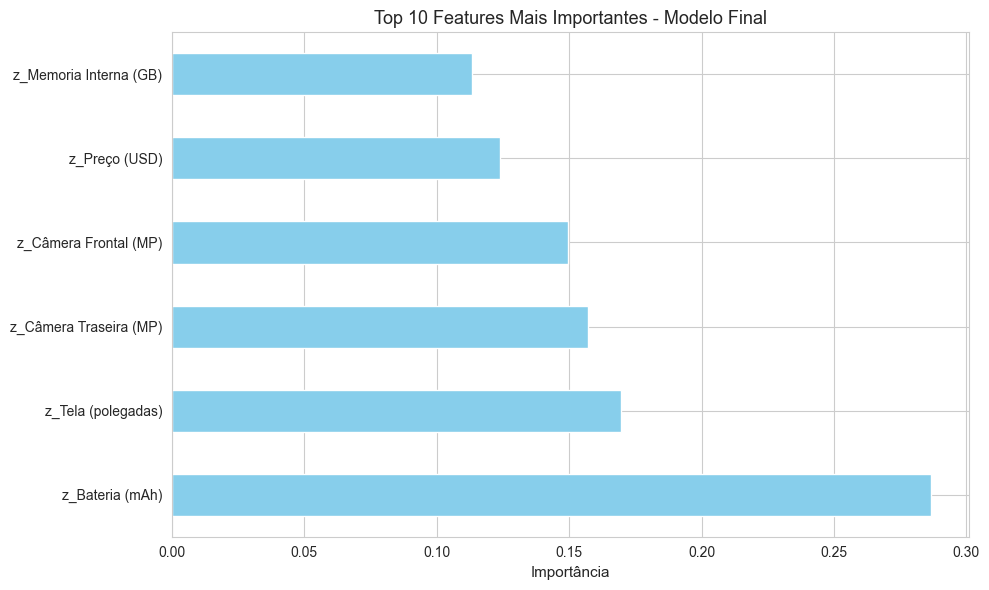

In [41]:
# Feature importance do modelo final
print(f"\n🔍 TOP FEATURES MAIS IMPORTANTES:")
feature_importance_final = pd.Series(final_model.feature_importances_, index=X.columns)
top_features = feature_importance_final.nlargest(10)

for i, (feature, importance) in enumerate(top_features.items(), 1):
    print(f"{i:2d}. {feature}: {importance:.3f}")

# Gráfico de feature importance
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='skyblue')
plt.title('Top 10 Features Mais Importantes - Modelo Final')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()

# print(f"\n🎉 MODELO FINAL PRONTO!")
# print(f"Técnica: {best_overall}")
# print(f"Parâmetros otimizados: ✅")
# print(f"Overfitting controlado: {'✅' if gap_final < 0.05 else '⚠️'}")
# print(f"Performance teste: {test_acc_final:.3f}")

# # Salvar informações do modelo final
# model_info = {
#     'technique': best_overall,
#     'best_params': rf_grid_final.best_params_,
#     'train_accuracy': train_acc_final,
#     'test_accuracy': test_acc_final,
#     'overfitting_gap': gap_final,
#     'cv_score': cv_scores_final.mean(),
#     'cv_std': cv_scores_final.std()
# }

# print(f"\n💾 Informações do modelo salvas na variável 'model_info'")

### Interpretabilidade do Modelo Final: SHAP



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


🎯 ANÁLISE SHAP - MODELO FINAL



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



🔧 Criando SHAP TreeExplainer...
✅ Valores SHAP calculados! Formato: 112 classes
SHAP Summary Plot - Beeswarm:


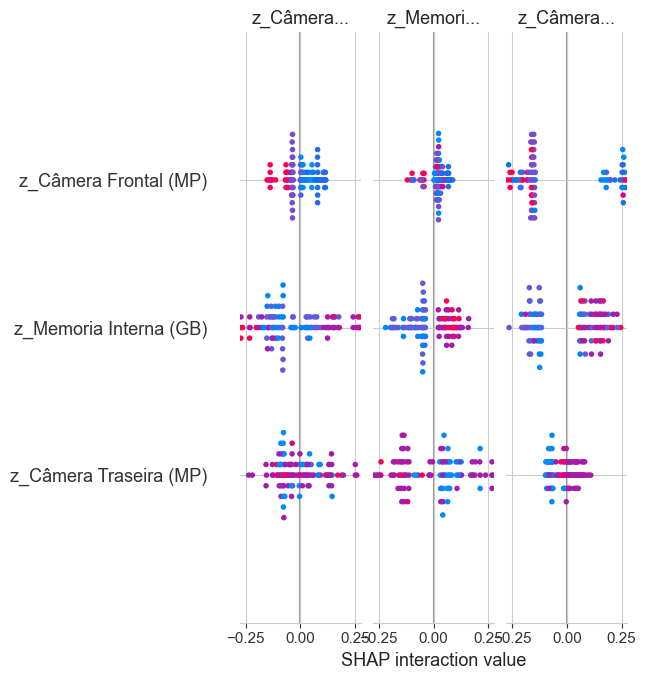


SHAP Summary Plot - Bar


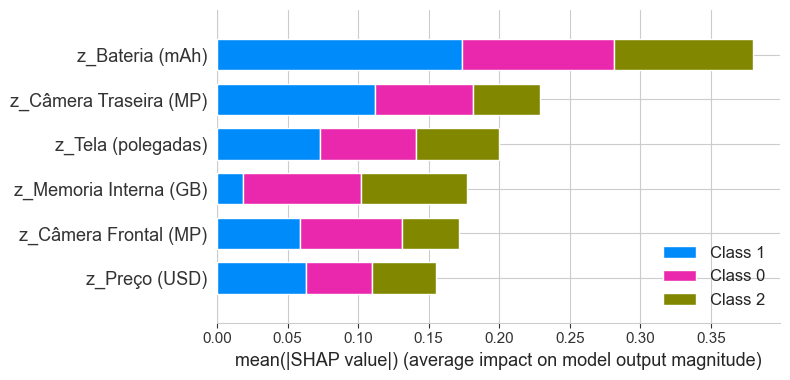

In [49]:

!pip install numpy==1.26.4
!pip install shap

import shap

# 1. Análise SHAP (SHapley Additive exPlanations)
print("="*70)
print("🎯 ANÁLISE SHAP - MODELO FINAL")
print("="*70)

# Inicializar SHAP
shap.initjs()

# Criar explainer para Random Forest
print("\n🔧 Criando SHAP TreeExplainer...")
explainer = shap.TreeExplainer(final_model)

# Use exatamente o mesmo X que vai ser analisado
X_shap = pd.DataFrame(X_test, columns=X.columns)
X_shap.head()

# Calcula os valores SHAP para os dados de teste
shap_values = explainer.shap_values(X_shap)

# Para classificação multiclasse, shap_values é uma lista de arrays
print(f"✅ Valores SHAP calculados! Formato: {len(shap_values)} classes")

# Summary plot (beeswarm)
print("SHAP Summary Plot - Beeswarm:")
shap.summary_plot(shap_values, X_shap)

print(f"\nSHAP Summary Plot - Bar")
shap.summary_plot(shap_values, X_shap, plot_type="bar")

### Arvore de decisao do RandomForest (Primeira arvore)

In [ ]:
# from sklearn.tree import plot_tree

# tree_plot = rf_model.estimators_[0]

# plt.figure(figsize=(20, 10))
# plot_tree(tree_plot, feature_names=X.columns, class_names=['Baixo', 'Médio', 'Alto'], filled=True, rounded=True)
# plt.title('Random Forest Tree Visualization')
# plt.show()